In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%matplotlib inline

# constants

In [4]:
cd /content/drive/MyDrive/Bone fracture


/content/drive/MyDrive/Bone fracture


In [5]:
IMG_SIZE = 224
DATA_DIR = "dataset"
TRAIN_DIR = 'train'
VAL_DIR = 'val'
TEST_DIR = 'test'
MODEL_PATH = 'saved-models/224-hist-binary2-more-train'

# histogram equalization

In [6]:
def equalize(img):
    img = img.astype('uint8')
    clahe = cv2.createCLAHE(tileGridSize=(8,8))
    img = clahe.apply(img)
    img = np.expand_dims(img, 2)
    return img

In [7]:
def compare_equalized(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = equalize(img).squeeze()
    img2 = np.hstack([img, img2])
    plt.imshow(img2, cmap='gray')
    plt.show()

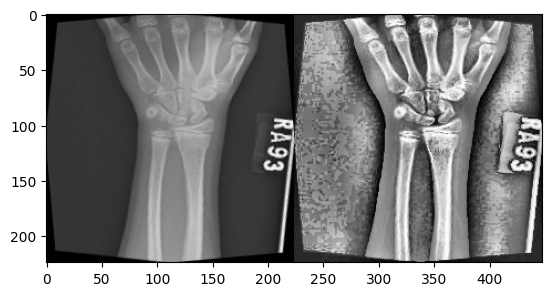

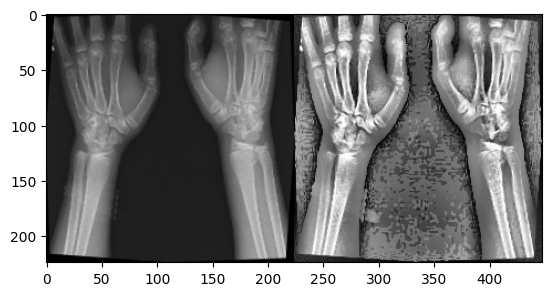

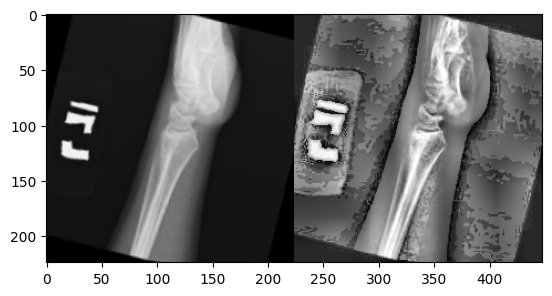

In [8]:
compare_equalized("/content/drive/MyDrive/Bone fracture/dataset/val/fractured/1-rotated1-rotated1-rotated2.jpg")
compare_equalized("/content/drive/MyDrive/Bone fracture/dataset/val/fractured/97-rotated2-rotated2.jpg")
compare_equalized("/content/drive/MyDrive/Bone fracture/dataset/val/fractured/99-rotated3-rotated1-rotated1.jpg")

# reading dataset (image data generators)

In [9]:
train_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)


val_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, VAL_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)


test_gen = ImageDataGenerator(preprocessing_function=equalize).flow_from_directory(
    directory=os.path.join(DATA_DIR, TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=64,
)

Found 4097 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 399 images belonging to 2 classes.


# cnn model

In [10]:
from tensorflow import keras
model = Sequential()

model.add(Conv2D(8, kernel_size=3, padding='same',  input_shape=train_gen[0][0][0].shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(16, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))

model.add(Conv2D(128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(Dense(train_gen[0][1].shape[1], activation='softmax'))

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Recall(), keras.metrics.SpecificityAtSensitivity(0.5) ])
model.summary()
#from keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       80        
                                                                 
 batch_normalization (Batch  (None, 224, 224, 8)       32        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 224, 224, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      1

# training

In [11]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
callbacks = [
            EarlyStopping(patience = 15, verbose=1),
            ReduceLROnPlateau(factor = 0.5, patience = 6, min_lr = 0.000001, verbose=1),
            ModelCheckpoint('model_bone.h5', monitor='val_loss', save_best_only=True,
            verbose=1)

    ]

hist = model.fit(
    train_gen,
    validation_data=val_gen,
    shuffle=True,
    epochs=80,
    callbacks=callbacks,
)


Epoch 1/80
65/65 [==============================] - ETA: 0s - loss: 3.7850 - accuracy: 0.6302 - recall: 0.6302 - specificity_at_sensitivity: 0.7349 
Epoch 1: val_loss improved from inf to 5.17057, saving model to model_bone.h5
65/65 [==============================] - 886s 13s/step - loss: 3.7850 - accuracy: 0.6302 - recall: 0.6302 - specificity_at_sensitivity: 0.7349 - val_loss: 5.1706 - val_accuracy: 0.4356 - val_recall: 0.4356 - val_specificity_at_sensitivity: 0.4035 - lr: 5.0000e-04


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/80
65/65 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.7139 - recall: 0.7139 - specificity_at_sensitivity: 0.8687
Epoch 2: val_loss improved from 5.17057 to 0.92636, saving model to model_bone.h5
65/65 [==============================] - 16s 244ms/step - loss: 0.8846 - accuracy: 0.7139 - recall: 0.7139 - specificity_at_sensitivity: 0.8687 - val_loss: 0.9264 - val_accuracy: 0.5569 - val_recall: 0.5569 - val_specificity_at_sensitivity: 0.6411 - lr: 5.0000e-04
Epoch 3/80
65/65 [==============================] - ETA: 0s - loss: 1.0934 - accuracy: 0.7464 - recall: 0.7464 - specificity_at_sensitivity: 0.8990
Epoch 3: val_loss did not improve from 0.92636
65/65 [==============================] - 16s 253ms/step - loss: 1.0934 - accuracy: 0.7464 - recall: 0.7464 - specificity_at_sensitivity: 0.8990 - val_loss: 0.9305 - val_accuracy: 0.5545 - val_recall: 0.5545 - val_specificity_at_sensitivity: 0.6015 - lr: 5.0000e-04
Epoch 4/80
65/65 [===========================

In [12]:
model.save("model.h5")

# training history (loss)

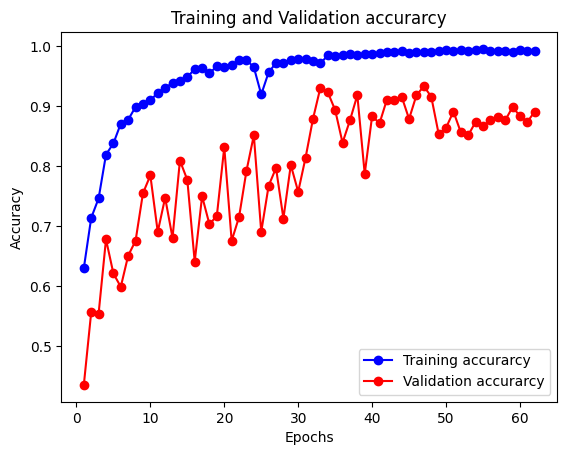

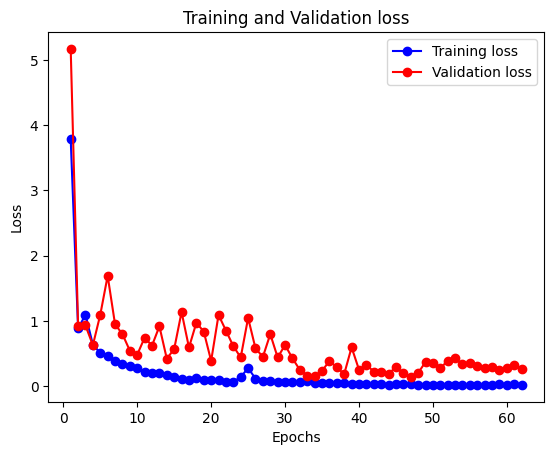

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# testing

In [14]:
from tensorflow import keras
model = keras.models.load_model('model.h5')

In [15]:
model.evaluate(test_gen)

7/7 [==============================] - 61s 10s/step - loss: 0.3053 - accuracy: 0.8697 - recall: 0.8697 - specificity_at_sensitivity: 0.9649


[0.30526795983314514,
 0.8696742057800293,
 0.8696742057800293,
 0.9649122953414917]

# confusion matrix

In [16]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)
print(y_pred_test,y_pred_test_int)

7/7 [==============================] - 2s 221ms/step
[[9.99069512e-01 9.30462789e-04]
 [9.98777330e-01 1.22270908e-03]
 [9.29936945e-01 7.00630620e-02]
 [4.48083313e-07 9.99999523e-01]
 [1.00000000e+00 3.01231839e-09]
 [1.21700011e-10 1.00000000e+00]
 [5.36424828e-11 1.00000000e+00]
 [9.70449507e-01 2.95505561e-02]
 [4.53636773e-08 1.00000000e+00]
 [1.00410269e-09 1.00000000e+00]
 [9.99986410e-01 1.35360406e-05]
 [2.15146108e-12 1.00000000e+00]
 [4.71609610e-06 9.99995232e-01]
 [1.68013281e-12 1.00000000e+00]
 [5.16536716e-07 9.99999523e-01]
 [3.18739936e-03 9.96812642e-01]
 [2.27849978e-06 9.99997735e-01]
 [9.99986172e-01 1.38113737e-05]
 [4.82916716e-04 9.99517083e-01]
 [1.23348916e-02 9.87665117e-01]
 [9.20545595e-09 1.00000000e+00]
 [1.90839071e-13 1.00000000e+00]
 [3.66988211e-11 1.00000000e+00]
 [9.99997616e-01 2.43390764e-06]
 [1.70685649e-02 9.82931435e-01]
 [4.72349541e-07 9.99999523e-01]
 [2.33377744e-08 1.00000000e+00]
 [5.81550630e-09 1.00000000e+00]
 [5.71213299e-10 1.0000

               precision    recall  f1-score   support

    fractured       0.99      0.74      0.85       199
not fractured       0.80      0.99      0.88       200

     accuracy                           0.87       399
    macro avg       0.89      0.87      0.87       399
 weighted avg       0.89      0.87      0.87       399



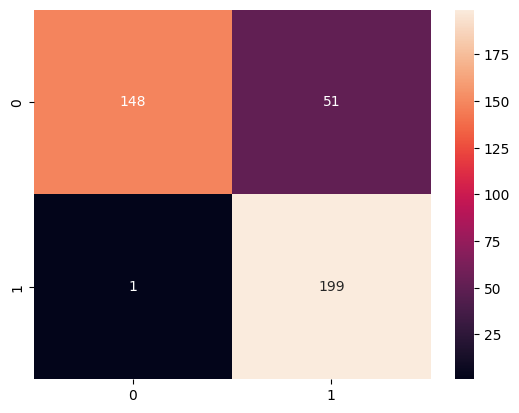

In [18]:
import seaborn as sn
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test_int, y_pred_test_int)
sn.heatmap(cm,annot=True,fmt="d")

target_names = ['fractured', 'not fractured']
print(classification_report(y_test_int, y_pred_test_int, target_names=target_names))

In [19]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_int, y_pred_test_int))

0.8696741854636592
